In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
model_code = survivalstan.models.pem_survival_model_randomwalk

In [11]:
print(model_code)

/*  Variable naming:
 // dimensions
 N          = total number of observations (length of data)
 S          = number of sample ids
 T          = max timepoint (number of timepoint ids)
 M          = number of covariates
 
 // main data matrix (per observed timepoint*record)
 s          = sample id for each obs
 t          = timepoint id for each obs
 event      = integer indicating if there was an event at time t for sample s
 x          = matrix of real-valued covariates at time t for sample n [N, X]
 
 // timepoint-specific data (per timepoint, ordered by timepoint id)
 t_obs      = observed time since origin for each timepoint id (end of period)
 t_dur      = duration of each timepoint period (first diff of t_obs)
 
*/
// Jacqueline Buros Novik <jackinovik@gmail.com>


data {
  // dimensions
  int<lower=1> N;
  int<lower=1> S;
  int<lower=1> T;
  int<lower=0> M;
  
  // data matrix
  int<lower=1, upper=N> s[N];     // sample id
  int<lower=1, upper=T> t[N];     // timepoint id
  int

In [12]:
d = stancache.cached(
    survivalstan.sim.sim_data_exp_correlated,
    N=100,
    censor_time=20,
    rate_form='1 + sex',
    rate_coefs=[-3, 0.5],
)
d['age_centered'] = d['age'] - d['age'].mean()
d.head()

INFO:stancache.stancache:sim_data_exp_correlated: cache_filename set to sim_data_exp_correlated.cached.N_100.censor_time_20.rate_coefs_54462717316.rate_form_1 + sex.pkl
INFO:stancache.stancache:sim_data_exp_correlated: Loading result from cache


,age,sex,rate,true_t,t,event,index,age_centered
0,56,male,0.082085,3.690371,3.690371,True,0,0.61
1,53,male,0.082085,1.574213,1.574213,True,1,-2.39
2,43,male,0.082085,29.095240,20.000000,False,2,-12.39
3,50,male,0.082085,1.017584,1.017584,True,3,-5.39
4,45,male,0.082085,40.317564,20.000000,False,4,-10.39


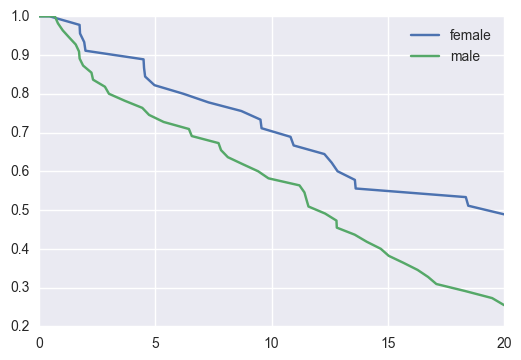

In [13]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

In [14]:
dlong = survivalstan.prep_data_long_surv(df=d, event_col='event', time_col='t')
dlong.sort_values(['index','end_time'], inplace=True)

In [ ]:
dlong.head()

,age,sex,rate,true_t,t,event,index,age_centered,key,end_time,end_failure
22,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,0.447637,False
24,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,0.676653,False
63,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,0.810536,False
3,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,1.017584,False
7,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,1.292124,False


In [ ]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = model_code,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_15125303112.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_15125303112.pystan_2_12_0_0.stanfit.chains_4.data_133439588.iter_5000.seed_9001.pkl
INFO:stancache.stancache:sampling: Starting execution


In [ ]:
survivalstan.utils.print_stan_summary([testfit], pars='lp__')

In [ ]:
survivalstan.utils.print_stan_summary([testfit], pars='log_baseline_raw')

In [ ]:
survivalstan.utils.plot_stan_summary([testfit], pars='log_baseline_raw')

In [ ]:
survivalstan.utils.plot_coefs([testfit], element='baseline')

In [ ]:
survivalstan.utils.plot_coefs([testfit])

In [ ]:
survivalstan.utils.plot_pp_survival([testfit], fill=False)
survivalstan.utils.plot_observed_survival(df=d, event_col='event', time_col='t', color='green', label='observed')
plt.legend()

In [ ]:
survivalstan.utils.plot_pp_survival([testfit], by='sex')